In [1]:
# Setup
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vocab.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
df.shape

(768, 13)

# Entity Embeddings

In [26]:
# make judge dummy variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df['author_id'].astype(str))
num_judges = max(J)+1
Y = df['x_republican'] > 0
Y2 = df['log_cite_count']

In [27]:
J[:10]

array([ 3, 10,  5,  4,  4,  9,  1,  3,  2,  3])

In [28]:
# set up DNN
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(num_judges, # number of categories
                    2, # dimensions of embedding
                    input_length=1)) 
model.add(Flatten()) # needed after Embedding
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#dot = model_to_dot(model,
#                   show_shapes=True,
#                   show_layer_names=False)
#SVG(dot.create(prog='dot', format='svg'))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 2)              22        
_________________________________________________________________
flatten_2 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


20/20 [==============================] - 0s 6ms/step - loss: 0.5425 - accuracy: 0.8925 - val_loss: 0.5271 - val_accuracy: 0.8766


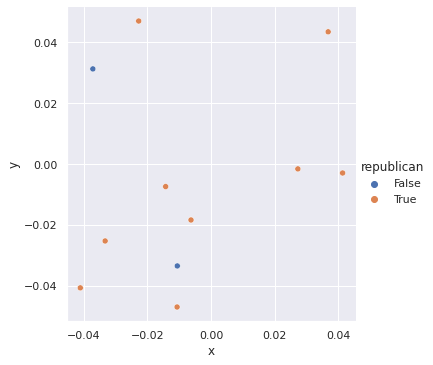

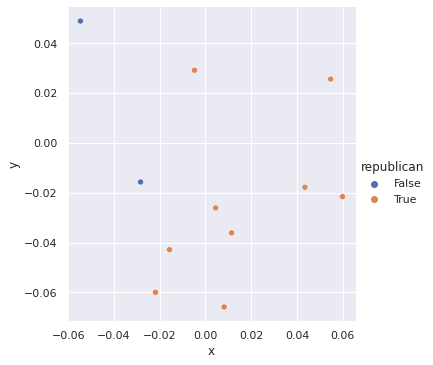

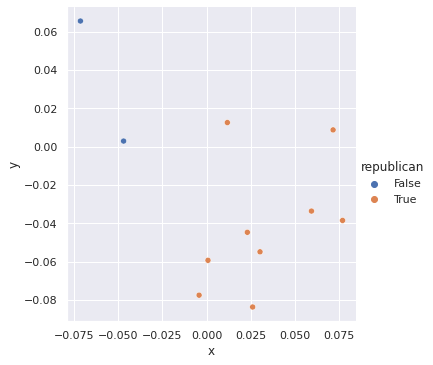

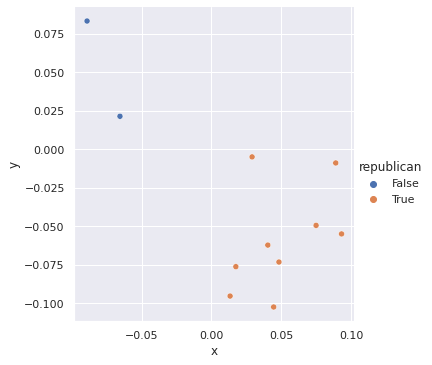

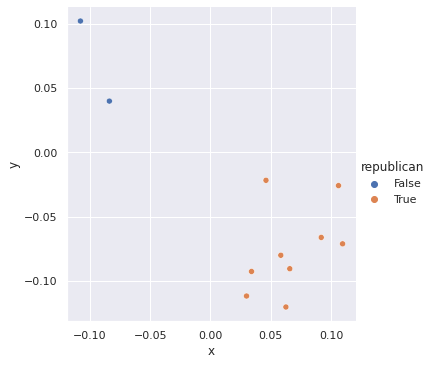

In [30]:
# Visualize the Judge Vectors
#!pip install ggplot
import seaborn as sns
sns.set_theme()

judge_cites = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['authorship']).drop_duplicates().sort_values('authorship')
df2['republican'] = df2['authorship'].apply(lambda x: judge_cites[x])

for i in range(5):
    if i > 0:
        model.fit(J,Y,epochs=1, validation_split=.2)
    
    judge_vectors = model.layers[0].get_weights()[0]
    df2['x'] = judge_vectors[:,0]
    df2['y'] = judge_vectors[:,1]    

    sns.relplot( data=df2, x="x", y="y", hue='republican', kind='scatter')


# Word Embeddings

In [31]:
# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['opinion_text'])
sequences = tokenizer.texts_to_sequences(df['opinion_text'])
len(sequences)

768

In [32]:
sequences[0]

[138,
 1,
 111,
 2,
 1,
 19,
 4,
 22,
 4,
 48,
 10,
 195,
 40,
 14,
 8,
 46,
 21,
 11,
 185,
 3,
 4,
 76,
 108,
 5,
 34,
 1,
 24,
 37,
 1,
 100,
 2,
 21,
 49,
 29,
 50,
 1,
 10,
 1,
 76,
 20,
 4,
 47,
 109,
 24,
 37,
 94,
 2,
 82,
 35,
 72,
 4,
 159,
 6,
 4,
 48,
 27,
 34,
 4,
 100,
 2,
 47,
 69,
 12,
 10,
 4,
 2,
 34,
 29,
 19,
 69,
 1,
 100,
 10,
 195,
 49,
 72,
 1,
 19,
 38,
 1,
 18,
 64,
 24,
 1,
 72,
 1,
 108,
 10,
 4,
 10,
 6,
 31,
 29,
 149,
 2,
 6,
 1,
 2,
 140,
 7,
 1,
 2,
 19,
 158,
 28,
 1,
 2,
 1,
 19,
 16,
 1,
 10,
 1,
 2,
 1,
 24,
 21,
 76,
 28,
 4,
 100,
 2,
 72,
 1,
 108,
 10,
 4,
 10,
 1,
 149,
 2,
 1,
 99,
 6,
 135,
 32,
 2,
 7,
 2,
 6,
 1,
 53,
 41,
 62,
 19,
 10,
 1,
 62,
 2,
 24,
 1,
 19,
 2,
 82,
 10,
 1,
 170,
 54,
 5,
 149,
 24,
 30,
 117,
 4,
 49,
 7,
 66,
 72,
 42,
 10,
 11,
 4,
 19,
 2,
 120,
 2,
 100,
 91,
 12,
 4,
 10,
 4,
 2,
 1,
 108,
 6,
 37,
 59,
 104,
 35,
 10,
 24,
 120,
 2,
 1,
 19,
 2,
 100,
 30,
 29,
 149,
 73,
 49,
 7,
 120,
 1,
 2,
 1,
 149,
 24,

In [33]:
# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 
maxlen

13971

In [34]:
X = pad_sequences(sequences, maxlen=maxlen)
X.shape

(768, 13971)

In [35]:
X[0]

array([ 0,  0,  0, ..., 20, 11, 81], dtype=int32)

In [36]:
X[0][maxlen-len(sequences[0]):]

array([138,   1, 111, ...,  20,  11,  81], dtype=int32)

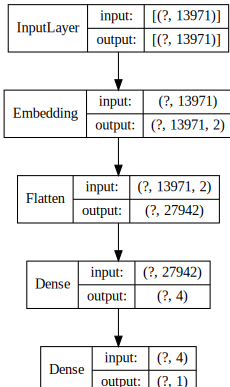

In [37]:
# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(4))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
from IPython.display import HTML
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)
dot = model_to_dot(model, show_shapes=True, show_layer_names=False,  dpi=70)
SVG(dot.create(prog='dot', format='svg'))

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 13971, 2)          400       
_________________________________________________________________
flatten_3 (Flatten)          (None, 27942)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 111772    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 112,177
Trainable params: 112,177
Non-trainable params: 0
_________________________________________________________________


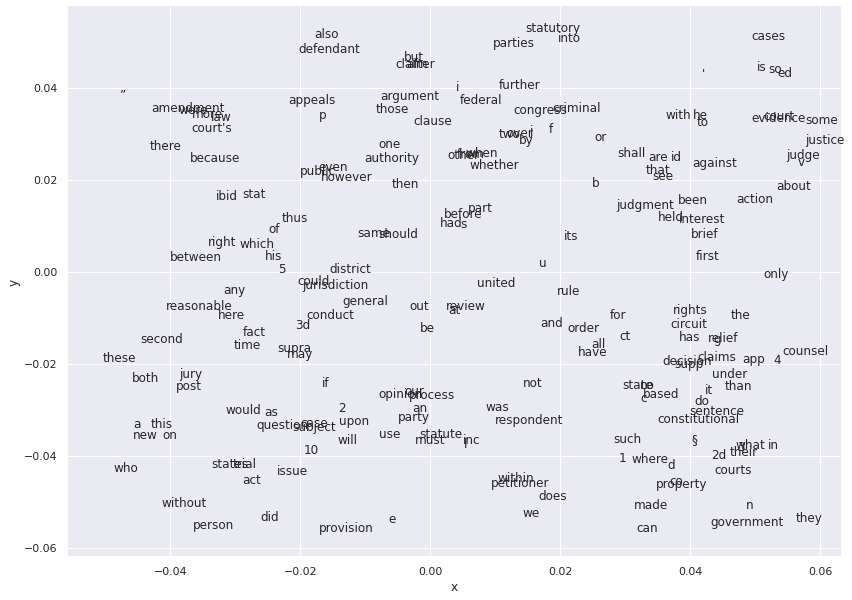

20/20 [==============================] - 1s 67ms/step - loss: 3.4274 - val_loss: 3.5648


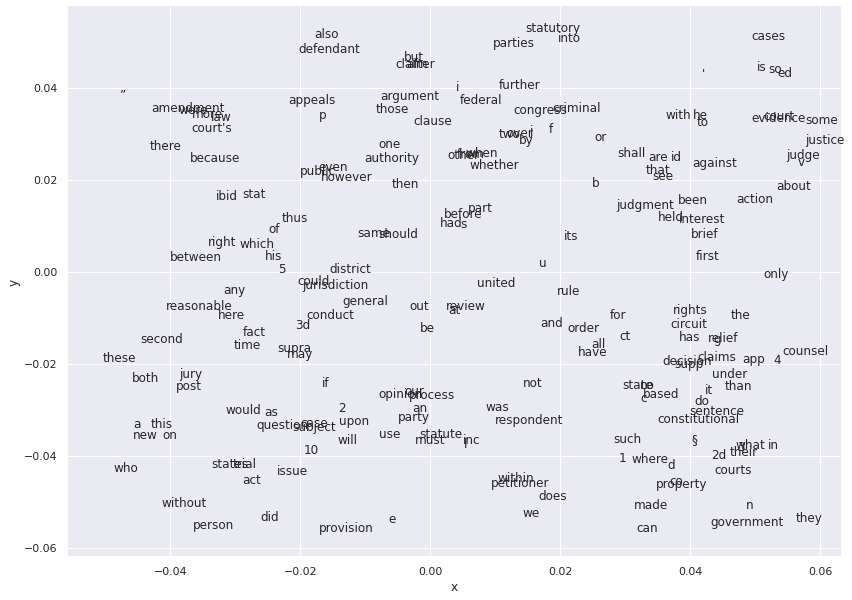

20/20 [==============================] - 1s 60ms/step - loss: 3.4274 - val_loss: 3.5648


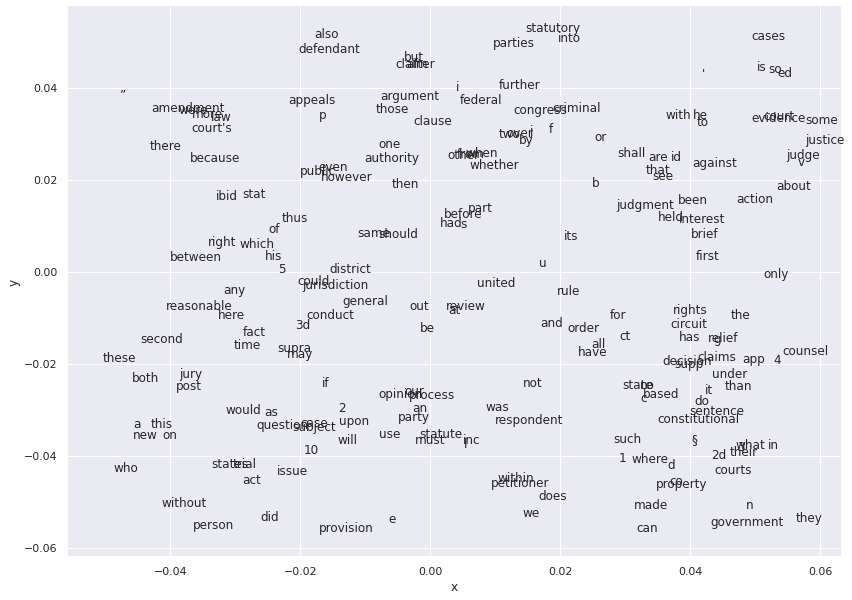

20/20 [==============================] - 1s 71ms/step - loss: 3.4274 - val_loss: 3.5648


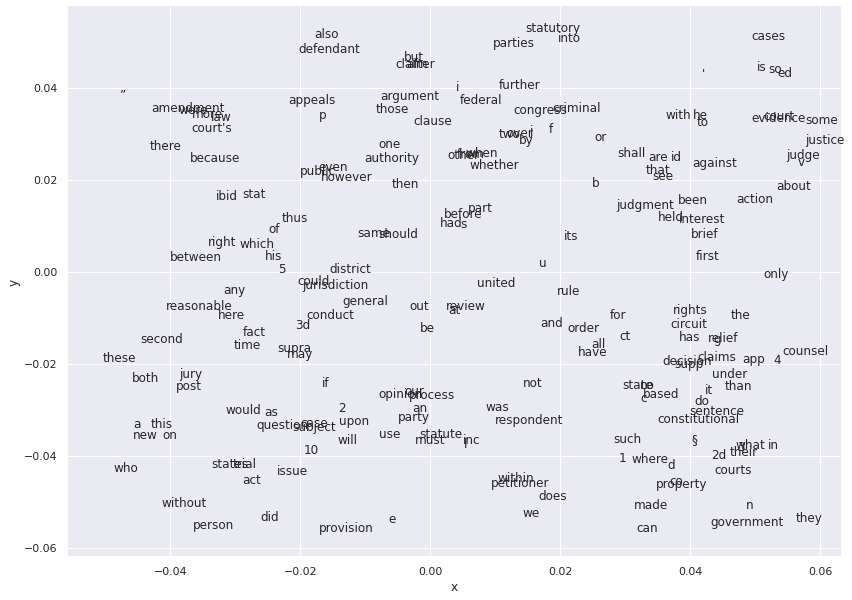

20/20 [==============================] - 1s 67ms/step - loss: 3.4274 - val_loss: 3.5648


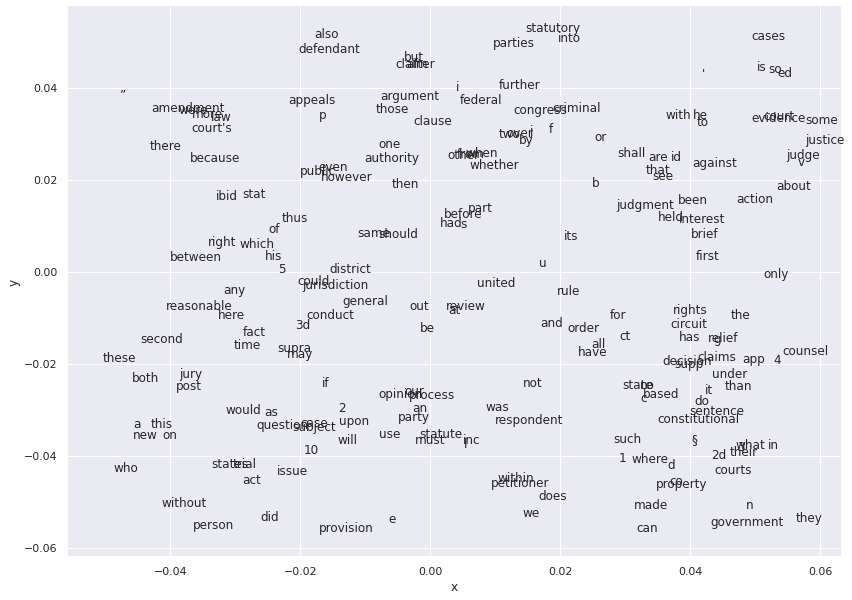

20/20 [==============================] - 1s 68ms/step - loss: 3.4274 - val_loss: 3.5648


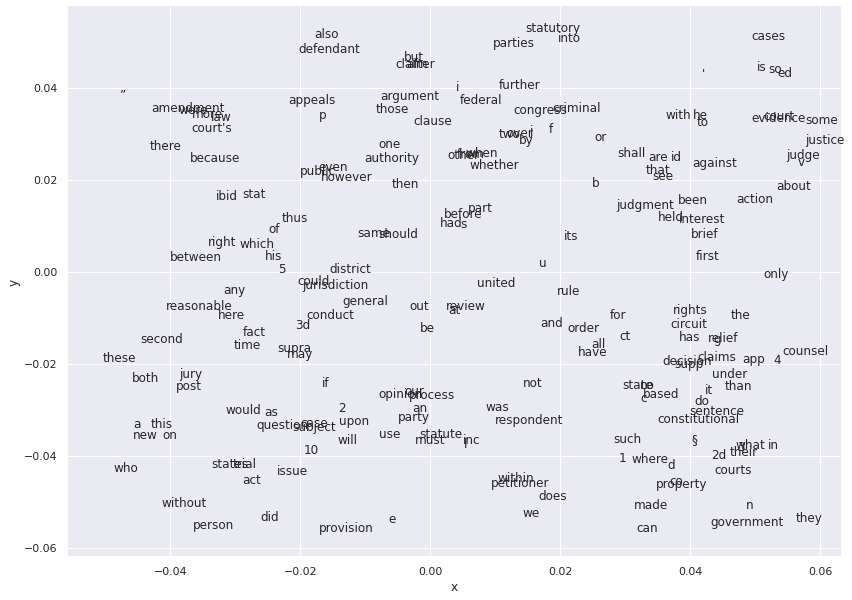

20/20 [==============================] - 1s 66ms/step - loss: 3.4274 - val_loss: 3.5648


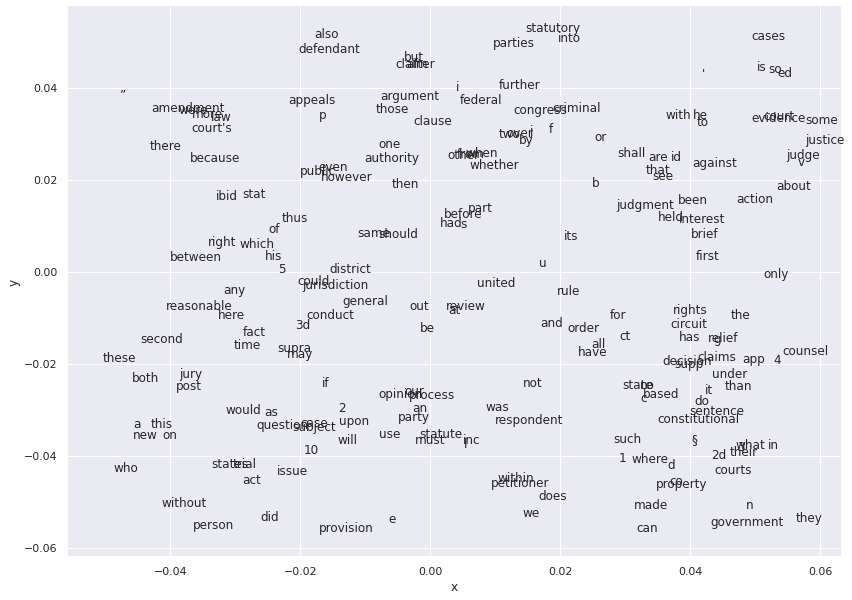

20/20 [==============================] - 1s 69ms/step - loss: 3.4274 - val_loss: 3.5648


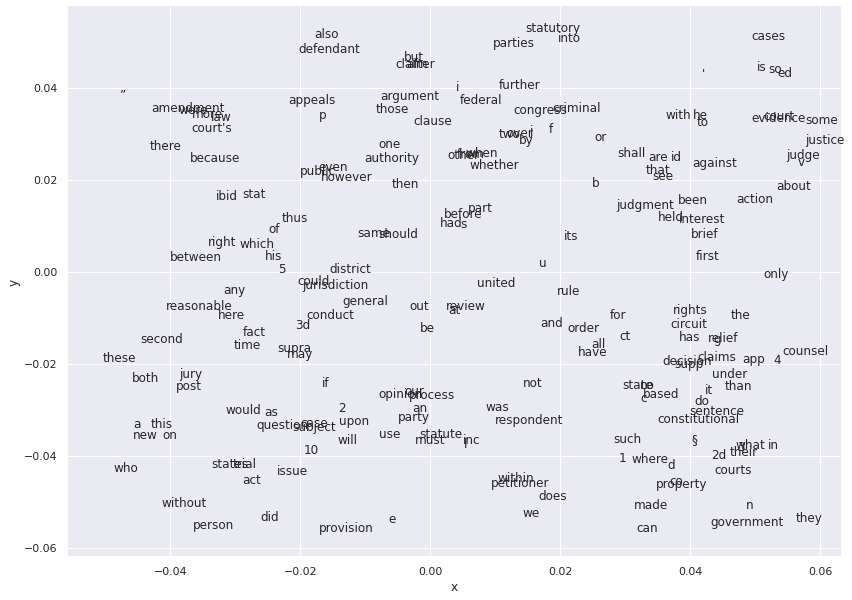

20/20 [==============================] - 1s 72ms/step - loss: 3.4274 - val_loss: 3.5648


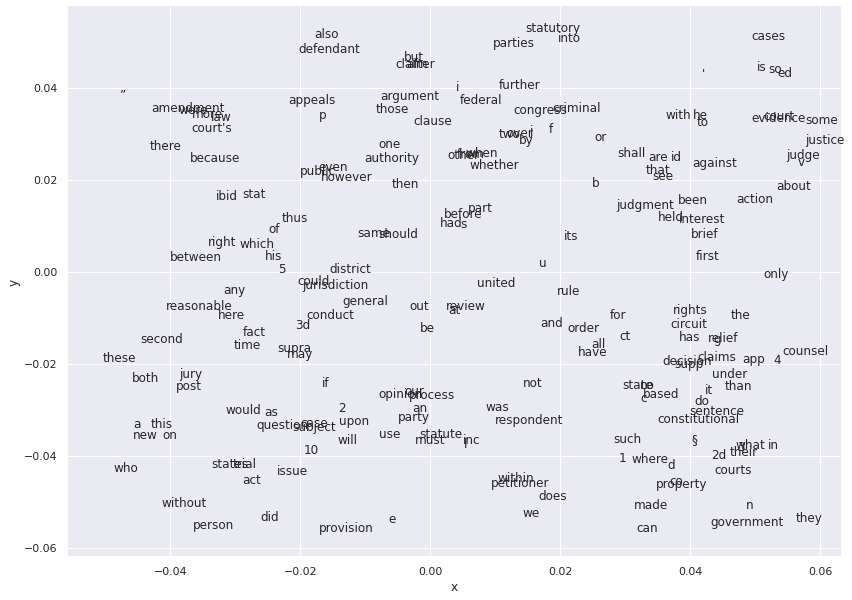

20/20 [==============================] - 2s 86ms/step - loss: 3.4274 - val_loss: 3.5648


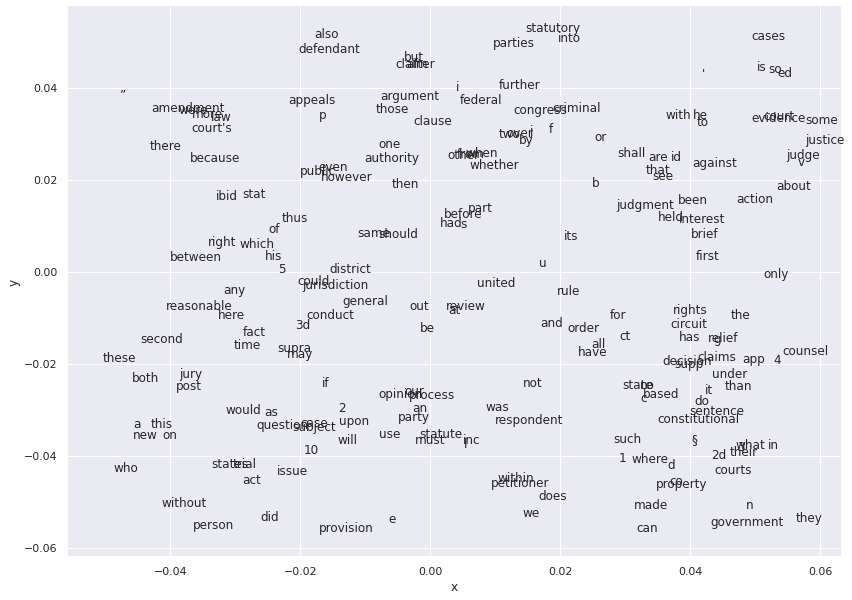

In [57]:
# show the vectors
from matplotlib import pyplot as plt

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(10):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df3['x'] = word_vectors[:,0]
    df3['y'] = word_vectors[:,1]

    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()


In [85]:
# Word Similarity
from scipy.spatial.distance import cosine

vec_defendants = word_vectors[tokenizer.word_index['defendant']-1]
vec_sent = word_vectors[tokenizer.word_index['sentence']-1]
vec_against = word_vectors[tokenizer.word_index['against']-1]

print(1-cosine(vec_defendants, vec_convicted))

-0.2830558121204376


In [86]:
print(1-cosine(vec_defendants, vec_against))

-0.15083077549934387


# Word2Vec in gensim

In [87]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([-9.49726850e-02,  2.22225618e-02,  2.01010220e-02, -2.00088590e-01,
       -3.85530330e-02,  7.10088164e-02, -3.15406546e-02,  1.08187072e-01,
       -1.00268826e-01,  5.75985536e-02, -3.44857620e-03, -1.84357345e-01,
        5.50540686e-02,  3.06810234e-02, -1.60534158e-02, -1.41220257e-01,
        2.38483772e-02, -9.49773714e-02, -5.41769573e-03,  4.67886627e-02,
       -1.09447762e-02, -1.74828768e-01, -2.53270511e-02,  3.23643610e-02,
        5.85882813e-02, -1.61287822e-02,  2.97410111e-03,  3.22719216e-02,
        1.34790328e-03, -1.04681320e-01,  8.66928976e-03,  8.74473772e-04,
        9.66649950e-02, -3.63491736e-02,  1.03594977e-02, -8.12641904e-02,
        4.46721260e-03,  4.46157483e-03, -3.57075781e-02,  1.39086559e-01,
       -1.29068330e-01,  4.54542413e-02, -1.78996511e-02, -1.54440198e-02,
        1.00031108e-01, -4.66025509e-02,  1.09919654e-02, -7.10386261e-02,
       -8.31815079e-02,  5.95630780e-02, -1.41372420e-02,  1.71858389e-02,
       -6.58002123e-02, -

In [88]:
w2v.wv.similarity('judg','juri') # similarity 

0.55980986

In [89]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.6328843832015991),
 ('juri', 0.5598098635673523),
 ('court', 0.5424550175666809),
 ('panel', 0.5136933922767639),
 ('prosecutor', 0.5118623971939087),
 ('imparti', 0.5100040435791016),
 ('magistr', 0.5023202896118164),
 ('speedi', 0.4942108392715454),
 ('unanim', 0.4918617010116577),
 ('factfind', 0.48124200105667114)]

In [90]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower#.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words ]#if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 0.0308123 , -0.04891719, -0.02399758,  0.00075945,  0.01689144,
       -0.04751686, -0.005778  ,  0.00178825, -0.03606154,  0.02995452,
       -0.09596141, -0.10209106,  0.0060487 , -0.07998896, -0.0683971 ,
       -0.06631173,  0.04859044,  0.02868996, -0.0935086 , -0.03584613,
       -0.00688847, -0.07613038,  0.01616668,  0.05397877,  0.05685357,
       -0.00531432,  0.02600554, -0.0148774 ,  0.01005817, -0.07870711,
        0.0139851 ,  0.02676784, -0.00084746,  0.07896686, -0.07286505,
        0.02892884,  0.0593002 ,  0.03784448, -0.03418217,  0.10505366,
       -0.11989726, -0.03349638, -0.05129416, -0.05140932,  0.04935802,
       -0.06274845, -0.04987079, -0.01614633,  0.08697261, -0.02074182,
       -0.01596636,  0.02529952, -0.05217844, -0.09765433, -0.08784064,
       -0.02534936,  0.00796632,  0.00854499,  0.01333253,  0.12098502,
       -0.04064848, -0.06863687, -0.0078241 ,  0.12180715, -0.05882024,
       -0.01290509, -0.07622105, -0.03441181, -0.01182316, -0.02

In [91]:
w2v.wv.similarity('judg','juri') # similarity 

0.6572243

In [92]:
w2v.wv.most_similar('judg') # most similar words

[('judge,', 0.8361478447914124),
 ('jury,', 0.6575326919555664),
 ('juri', 0.6572242975234985),
 ('judge.', 0.6114718914031982),
 ('court', 0.5724461078643799),
 ('panel', 0.5647722482681274),
 ('prosecutor', 0.5591201782226562),
 ('magistr', 0.5391689538955688),
 ('presid', 0.5358769297599792),
 ('juror', 0.5302377343177795)]

In [93]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('judge,', 0.7661195397377014),
 ('jury,', 0.5785614252090454),
 ('juri', 0.5422350764274597),
 ('court,', 0.5319039821624756),
 ('court', 0.5301183462142944),
 ('prosecutor', 0.49816498160362244),
 ('judge.', 0.4877251386642456),
 ('juror', 0.4746873676776886),
 ('magistr', 0.4657633304595947),
 ('panel', 0.4640374481678009)]

In [97]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.vocab['judg'].index]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index2word[i])

was
his
petition
he
respond
been
defend


# Pre-trained vectors

In [58]:
import spacy
en = spacy.load('en_core_web_sm')
apple = en('apple') 
apple.vector # vector for 'apple'

array([ 0.1563062 ,  0.32511786,  0.2863136 , -0.72162384, -0.42168996,
        0.14712515, -0.02182803, -0.9481735 , -0.575407  , -0.5256307 ,
        0.27461338, -0.17462277,  0.1607259 ,  0.4055855 , -0.35179895,
        1.1695373 ,  0.8666519 , -0.68381345, -0.08561775,  0.20118119,
        0.17342699,  0.0358507 , -0.7725097 ,  1.0828099 , -1.0817364 ,
        0.7373781 ,  0.58742875, -0.17263329,  0.35065913,  0.18138093,
       -0.9616474 , -1.158772  , -0.45887533, -0.99167395,  1.5415051 ,
        0.6103588 , -1.022373  , -0.10990372, -0.01469573,  1.2498648 ,
       -1.1099627 , -1.1592076 , -0.5363296 ,  1.5863433 , -0.48288727,
       -0.09400067, -0.04509206,  0.7673515 ,  0.16819337, -0.99536693,
        0.5015171 ,  0.8336173 , -0.89051384,  0.4164316 ,  0.5697347 ,
       -0.5383322 ,  1.3724039 , -0.19763762,  1.2409675 ,  0.27657515,
       -0.4066952 , -0.7676145 , -0.5987829 , -0.1680414 , -0.7812945 ,
       -0.0297612 , -0.06602472, -0.28612745,  0.4767033 , -0.59

In [59]:
apple.similarity(apple)

1.0

In [60]:
orange = en('orange')
apple.similarity(orange)

0.6091243723051054

In [61]:
import spacy
#!python -m spacy download de_core_news_sm
de = spacy.load('de_core_news_sm')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

0.32536950413311805

In [62]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in tokenizer.word_index.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [63]:
model = Sequential()
model.add(Embedding(num_words,
                    embed_dims,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False)) # frozen layer
model.add(Flatten()) # 86*300 = 25800 dims
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 13971, 96)         19200     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1341216)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                85837888  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 85,857,153
Trainable params: 85,837,953
Non-trainable params: 19,200
_________________________________________________________________


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.952822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.631287
[t-SNE] KL divergence after 300 iterations: 0.539171


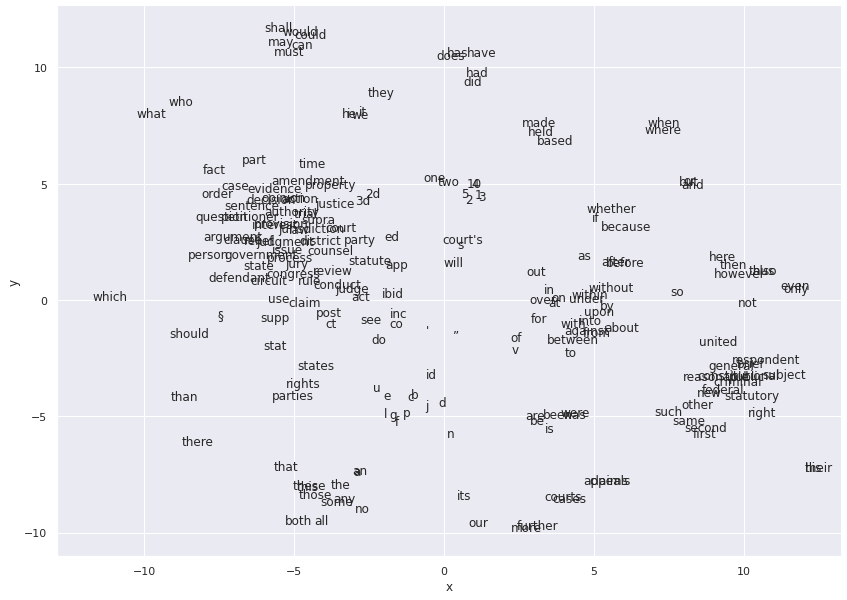

20/20 [==============================] - 6s 302ms/step - loss: 3.4795 - accuracy: 0.7622 - val_loss: 3.5648 - val_accuracy: 0.7662
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.952822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.019367
[t-SNE] KL divergence after 300 iterations: 0.526239


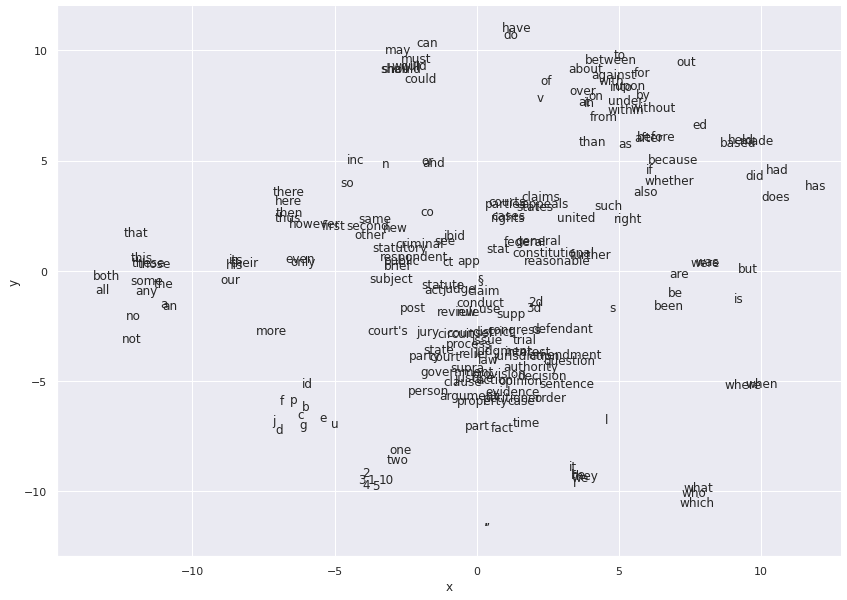

20/20 [==============================] - 7s 329ms/step - loss: 3.4274 - accuracy: 0.7752 - val_loss: 3.5648 - val_accuracy: 0.7662
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.952822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.612125
[t-SNE] KL divergence after 300 iterations: 0.507235


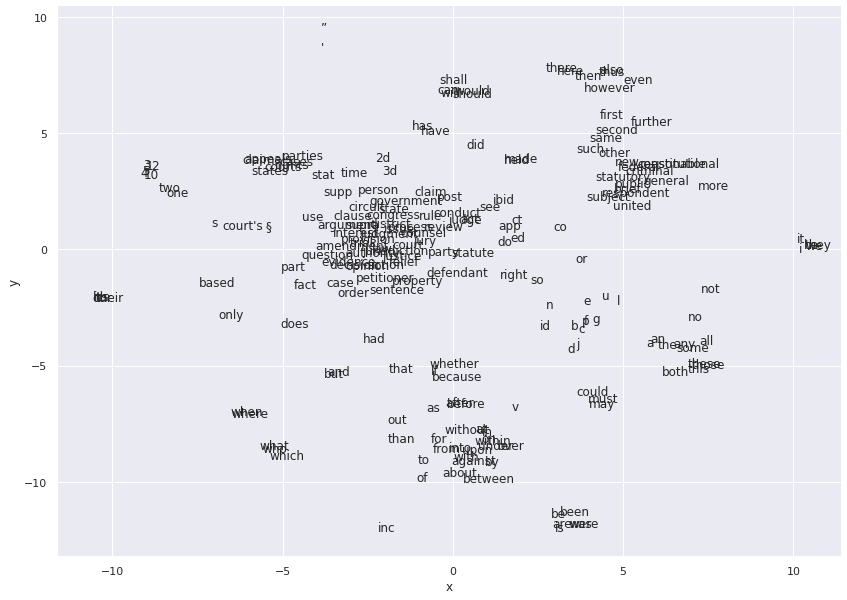

In [65]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)
    
    word_vectors = model.layers[0].get_weights()[0]
    wv_tsne = tsne.fit_transform(word_vectors)

    df3['x'] = wv_tsne[:,0]
    df3['y'] = wv_tsne[:,1]
    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()

# GloVe

In [19]:
#!pip install glove-python-binary for python >3.6
#!pip install glove_python for other versions

import itertools
from glove import Corpus, Glove

from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

corpus = Corpus()
corpus.fit(sentences, window=10)
glove = Glove(no_components=100, learning_rate=0.05)

In [20]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [21]:
glove.word_vectors[glove.dictionary['judg']]

array([ 0.17849652, -0.47911134, -0.34244749, -0.3118544 , -0.38617919,
        0.35372504,  0.1396503 , -0.37891838,  0.3625124 ,  0.31792561,
        0.31869681,  0.34803812, -0.34437468, -0.58277565, -0.18902753,
       -0.44123249, -0.16312407,  0.19188276, -0.07210751, -0.01775385,
       -0.16320215, -0.26949895, -0.00447028, -0.22485262, -0.17890927,
        0.38660538, -0.20083946, -0.32364059,  0.04843658,  0.43422379,
       -0.20156965,  0.17337558, -0.04645053, -0.15544417, -0.44802809,
       -0.31907284,  0.21564701,  0.24955782, -0.41696303,  0.29923716,
       -0.44435882, -0.32053426, -0.33329453, -0.39997234,  0.01663491,
        0.12102572, -0.09601709,  0.20221887, -0.27130004, -0.03378083,
       -0.20849948,  0.27377382, -0.30703866, -0.14390558, -0.26436764,
       -0.40756201,  0.46378541,  0.18660603,  0.14944868,  0.27749368,
        0.22460054, -0.7378603 , -0.28935838, -0.30069662,  0.26650418,
       -0.2193524 , -0.1091098 , -0.23273368,  0.26007884,  0.29

In [25]:
glove.most_similar('judg')

[('magistr', 0.8588146388126814),
 ('dawson', 0.7297045284034197),
 ('couvillion', 0.698992014423276),
 ('trial', 0.6685768858145842)]


# Word Mover Distance

In [3]:
import spacy
import wmd
nlp = spacy.load('en_core_web_sm', 
                 create_pipeline=wmd.WMD.create_spacy_pipeline)
doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")
print(doc1.similarity(doc2))

0.7725510546692099


/home/dominsta/anaconda3/envs/legal_dna/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if sys.path[0] == '':
